<a href="https://colab.research.google.com/github/kashika3101/IDS/blob/main/Intrusion_Detection_using_Machine_Learning_Techniques.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Environment Setup

In [ ]:
# import relevant modules
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
import imblearn

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Settings
pd.set_option('display.max_columns', None)
np.set_printoptions(threshold=np.inf, linewidth=np.nan)
#np.set_printoptions(threshold=np.nan)
np.set_printoptions(precision=3)
sns.set(style="darkgrid")
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

print("pandas : {0}".format(pd.__version__))
print("numpy : {0}".format(np.__version__))
print("matplotlib : {0}".format(matplotlib.__version__))
print("seaborn : {0}".format(sns.__version__))
print("sklearn : {0}".format(sklearn.__version__))
print("imblearn : {0}".format(imblearn.__version__))

pandas : 1.5.3
numpy : 1.22.4
matplotlib : 3.7.1
seaborn : 0.12.2
sklearn : 1.2.2
imblearn : 0.10.1


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Load Data

In [ ]:
# Dataset field names
datacols = ["duration","protocol_type","service","flag","src_bytes",
    "dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
    "logged_in","num_compromised","root_shell","su_attempted","num_root",
    "num_file_creations","num_shells","num_access_files","num_outbound_cmds",
    "is_host_login","is_guest_login","count","srv_count","serror_rate",
    "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
    "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate","attack", "last_flag"]

# Load NSL_KDD train dataset
dfkdd_train = pd.read_table("/content/drive/MyDrive/NSL_KDD_dataset/KDDTrain.txt", sep=",", names=datacols) # change path to where the dataset is located.
dfkdd_train = dfkdd_train.iloc[:,:-1] # removes an unwanted extra field

# Load NSL_KDD test dataset
dfkdd_test = pd.read_table("/content/drive/MyDrive/NSL_KDD_dataset/KDDTest.txt", sep=",", names=datacols)
dfkdd_test = dfkdd_test.iloc[:,:-1]

### Train dataset

In [ ]:
# View train data
dfkdd_train.head(3)

# train set dimension
print('Train set dimension: {} rows, {} columns'.format(dfkdd_train.shape[0], dfkdd_train.shape[1]))

Train set dimension: 125973 rows, 42 columns


### Test dataset

In [ ]:
# View test data
dfkdd_test.head(3)

# test set dimension
print('Test set dimension: {} rows, {} columns'.format(dfkdd_test.shape[0], dfkdd_test.shape[1]))

Test set dimension: 22544 rows, 42 columns


## Data Preprocessing

### Map attack field to attack class 
NSL-KDD dataset has 42 attributes for each connection record including class label containing attack types. The attack types are categorized into four attack classes as described by Mahbod Tavallaee et al. in [_A Detailed analysis of the KDD CUP 99 Data Set_](http://www.ee.ryerson.ca/~bagheri/papers/cisda.pdf) as:
1. **Denial of Service (DoS)**: is an attack in which an adversary directed a deluge of traffic requests to a system in order to make the computing or memory resource too busy or too full to handle legitimate requests and in the process, denies legitimate users access to a machine.
2. **Probing Attack (Probe)**: probing network of computers to gather information to be used to compromise its security controls. 
3. **User to Root Attack (U2R)**: a class of exploit in which the adversary starts out with access to a normal user account on the system (gained either by sniffing passwords, a dictionary attack, or social engineering) and is able to exploit some vulnerability to gain root access to the system. 
4. **Remote to Local Attack (R2L)**: occurs when an attacker who has the ability to send packets to a machine over a network but who does not have an account on that machine exploits some vulnerability to gain local access as a user of that machine. 

In [ ]:
mapping = {'ipsweep': 'Probe','satan': 'Probe','nmap': 'Probe','portsweep': 'Probe','saint': 'Probe','mscan': 'Probe',
        'teardrop': 'DoS','pod': 'DoS','land': 'DoS','back': 'DoS','neptune': 'DoS','smurf': 'DoS','mailbomb': 'DoS',
        'udpstorm': 'DoS','apache2': 'DoS','processtable': 'DoS',
        'perl': 'U2R','loadmodule': 'U2R','rootkit': 'U2R','buffer_overflow': 'U2R','xterm': 'U2R','ps': 'U2R',
        'sqlattack': 'U2R','httptunnel': 'U2R',
        'ftp_write': 'R2L','phf': 'R2L','guess_passwd': 'R2L','warezmaster': 'R2L','warezclient': 'R2L','imap': 'R2L',
        'spy': 'R2L','multihop': 'R2L','named': 'R2L','snmpguess': 'R2L','worm': 'R2L','snmpgetattack': 'R2L',
        'xsnoop': 'R2L','xlock': 'R2L','sendmail': 'R2L',
        'normal': 'Normal'
        }

In [ ]:
# Apply attack class mappings to the dataset
dfkdd_train['attack_class'] = dfkdd_train['attack'].apply(lambda v: mapping[v])
dfkdd_test['attack_class'] = dfkdd_test['attack'].apply(lambda v: mapping[v])

In [ ]:
# Drop attack field from both train and test data
dfkdd_train.drop(['attack'], axis=1, inplace=True)
dfkdd_test.drop(['attack'], axis=1, inplace=True)

In [ ]:
# View top 3 train data 
dfkdd_train.head(3)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack_class
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.00,0.00,0.0,150,25,0.17,0.03,0.17,0.0,0.0,0.0,0.05,0.0,Normal
1,0,udp,other,SF,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.0,0.0,0.0,0.0,0.08,0.15,0.0,255,1,0.00,0.60,0.88,0.0,0.0,0.0,0.00,0.0,Normal
2,0,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1.0,1.0,0.0,0.0,0.05,0.07,0.0,255,26,0.10,0.05,0.00,0.0,1.0,1.0,0.00,0.0,DoS


### Exploratory Data Analysis

In [ ]:
# Descriptive statistics
dfkdd_train.describe()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
count,125973.00000,1.259730e+05,1.259730e+05,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.0,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000
mean,287.14465,4.556674e+04,1.977911e+04,0.000198,0.022687,0.000111,0.204409,0.001222,0.395736,0.279250,0.001342,0.001103,0.302192,0.012669,0.000413,0.004096,0.0,0.000008,0.009423,84.107555,27.737888,0.284485,0.282485,0.119958,0.121183,0.660928,0.063053,0.097322,182.148945,115.653005,0.521242,0.082951,0.148379,0.032542,0.284452,0.278485,0.118832,0.120240
std,2604.51531,5.870331e+06,4.021269e+06,0.014086,0.253530,0.014366,2.149968,0.045239,0.489010,23.942042,0.036603,0.045154,24.399618,0.483935,0.022181,0.099370,0.0,0.002817,0.096612,114.508607,72.635840,0.446456,0.447022,0.320436,0.323647,0.439623,0.180314,0.259830,99.206213,110.702741,0.448949,0.188922,0.308997,0.112564,0.444784,0.445669,0.306557,0.319459
min,0.00000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.00000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.090000,0.000000,0.000000,82.000000,10.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.00000,4.400000e+01,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,14.000000,8.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,255.000000,63.000000,0.510000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.00000,2.760000e+02,5.160000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,143.000000,18.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.060000,0.000000,255.000000,255.000000,1.000000,0.070000,0.060000,0.020000,1.000000,1.000000,0.000000,0.000000
max,42908.00000,1.379964e+09,1.309937e+09,1.000000,3.000000,3.000000,77.000000,5.000000,1.000000,7479.000000,1.000000,2.000000,7468.000000,43.000000,2.000000,9.000000,0.0,1.000000,1.000000,511.000000,511.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,255.000000,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
dfkdd_train['num_outbound_cmds'].value_counts()
dfkdd_test['num_outbound_cmds'].value_counts()

0    22544
Name: num_outbound_cmds, dtype: int64

In [ ]:
# 'num_outbound_cmds' field has all 0 values. Hence, it will be removed from both train and test dataset since it is a redundant field.
dfkdd_train.drop(['num_outbound_cmds'], axis=1, inplace=True)
dfkdd_test.drop(['num_outbound_cmds'], axis=1, inplace=True)

In [ ]:
# Attack Class Distribution
attack_class_freq_train = dfkdd_train[['attack_class']].apply(lambda x: x.value_counts())
attack_class_freq_test = dfkdd_test[['attack_class']].apply(lambda x: x.value_counts())
attack_class_freq_train['frequency_percent_train'] = round((100 * attack_class_freq_train / attack_class_freq_train.sum()),2)
attack_class_freq_test['frequency_percent_test'] = round((100 * attack_class_freq_test / attack_class_freq_test.sum()),2)

attack_class_dist = pd.concat([attack_class_freq_train,attack_class_freq_test], axis=1) 
attack_class_dist

,attack_class,frequency_percent_train,attack_class,frequency_percent_test
Normal,67343,53.46,9711,43.08
DoS,45927,36.46,7458,33.08
Probe,11656,9.25,2421,10.74
R2L,995,0.79,2754,12.22
U2R,52,0.04,200,0.89


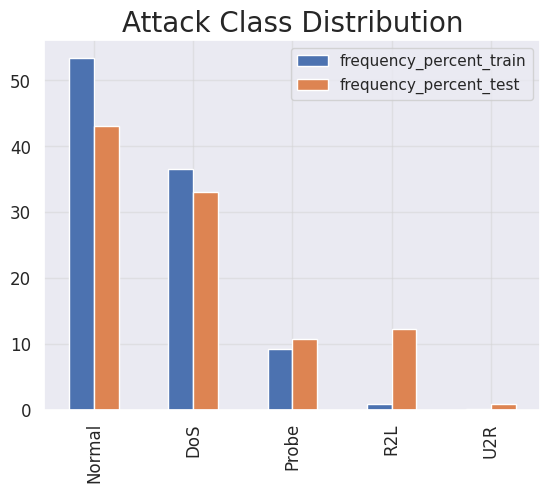

In [ ]:
# Attack class bar plot
plot = attack_class_dist[['frequency_percent_train', 'frequency_percent_test']].plot(kind="bar");
plot.set_title("Attack Class Distribution", fontsize=20);
plot.grid(color='lightgray', alpha=0.5);

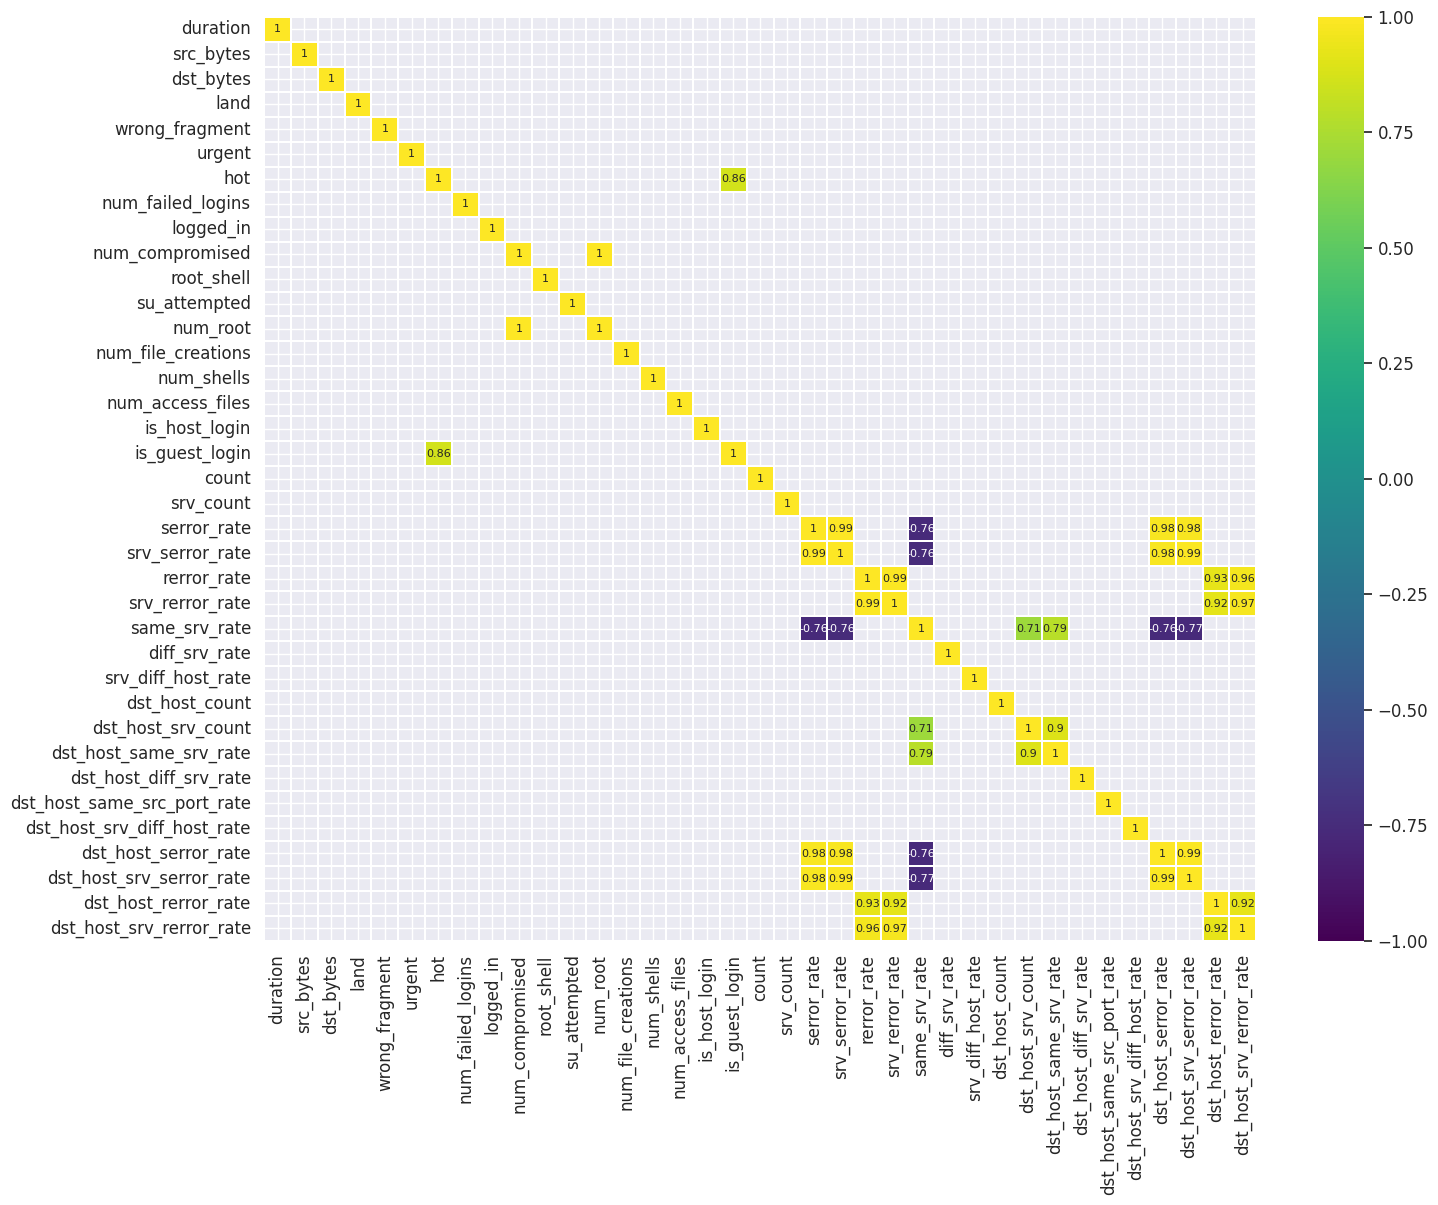

In [ ]:
# Analysing feature to feature relationship

dfkdd_num = dfkdd_train.select_dtypes(include = ['float64', 'int64'])
corr = dfkdd_train.corr()
plt.figure(figsize=(16, 12))

sns.heatmap(corr[(corr >= 0.7) | (corr <= -0.7)], 
            cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 8});

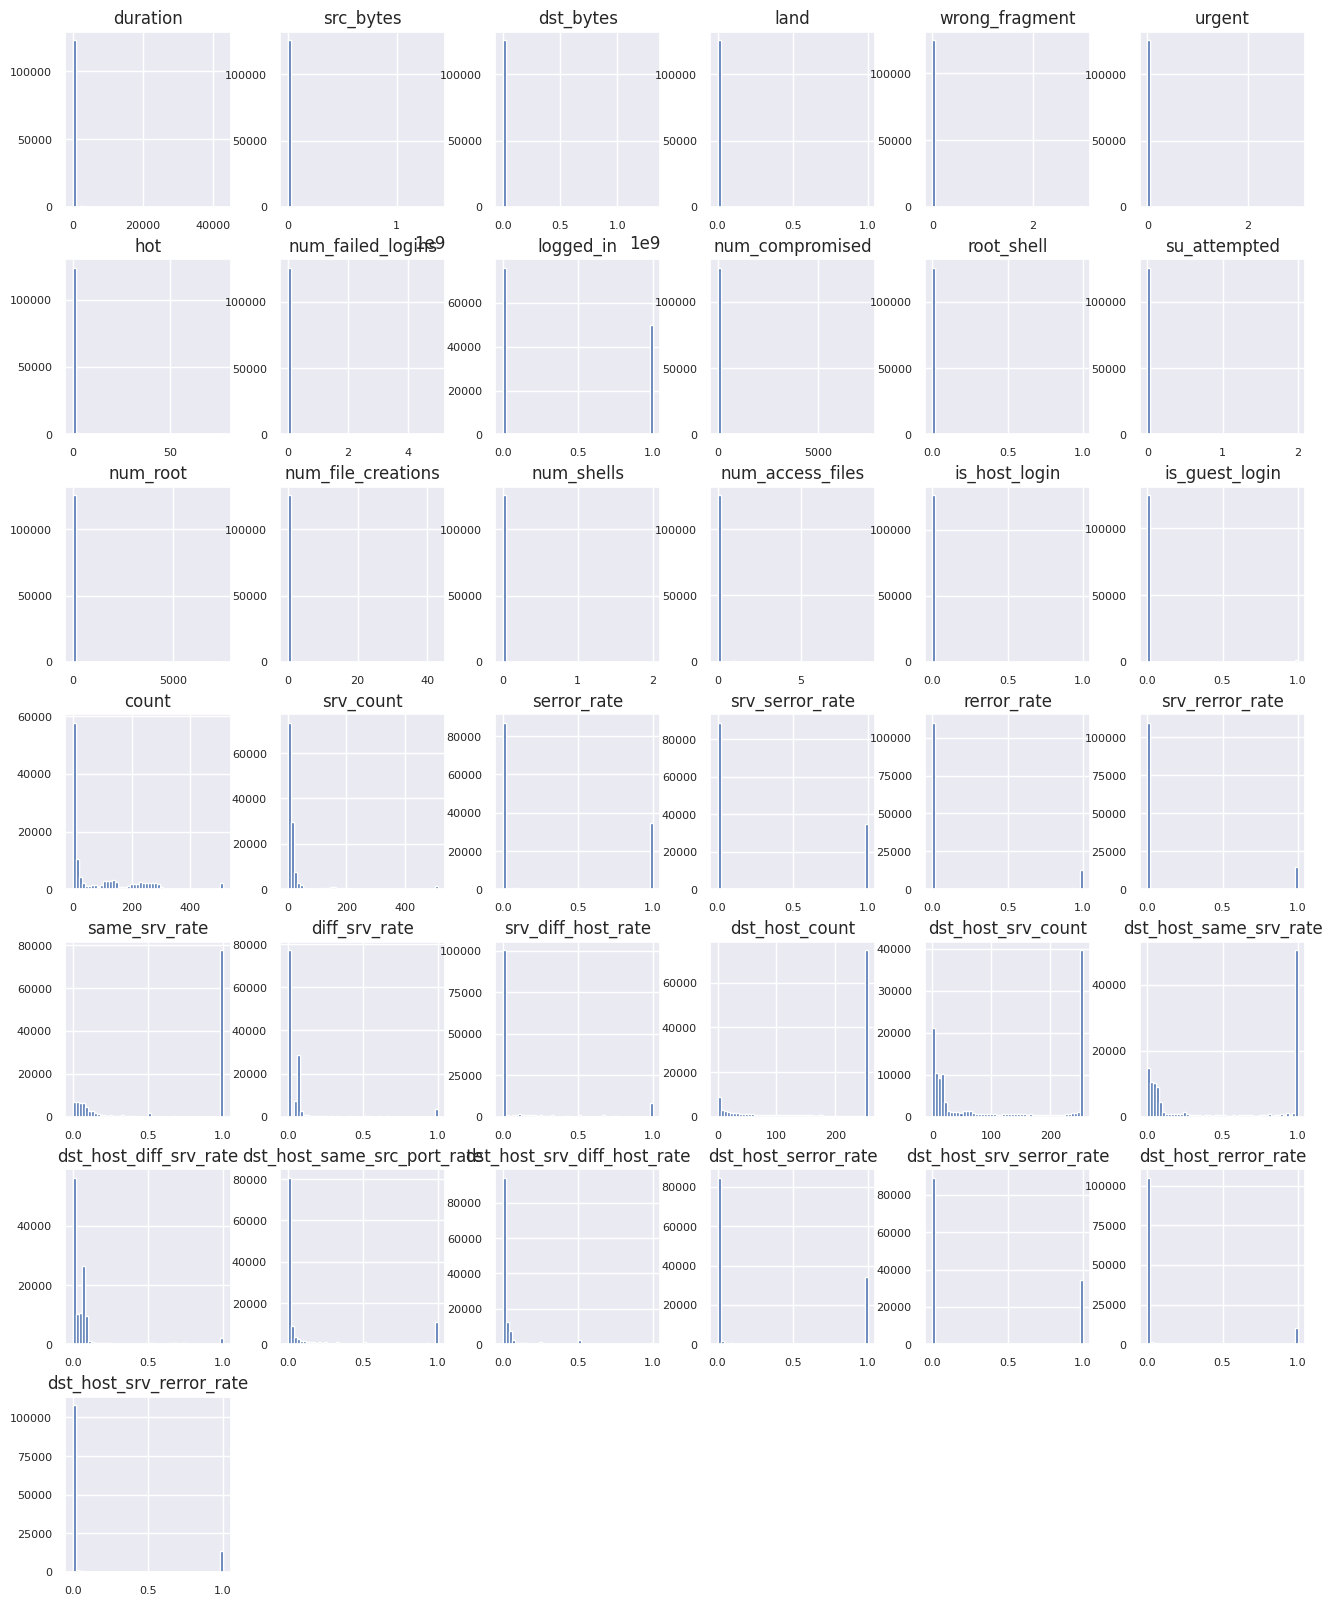

In [ ]:
 #Distribution of predictors/features
# A `histogram`_ is a representation of the distribution of data
# This function calls `matplotlib.pyplot.hist`, on each series in the DataFrame
# resulting in one histogram per column
dfkdd_num.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8);

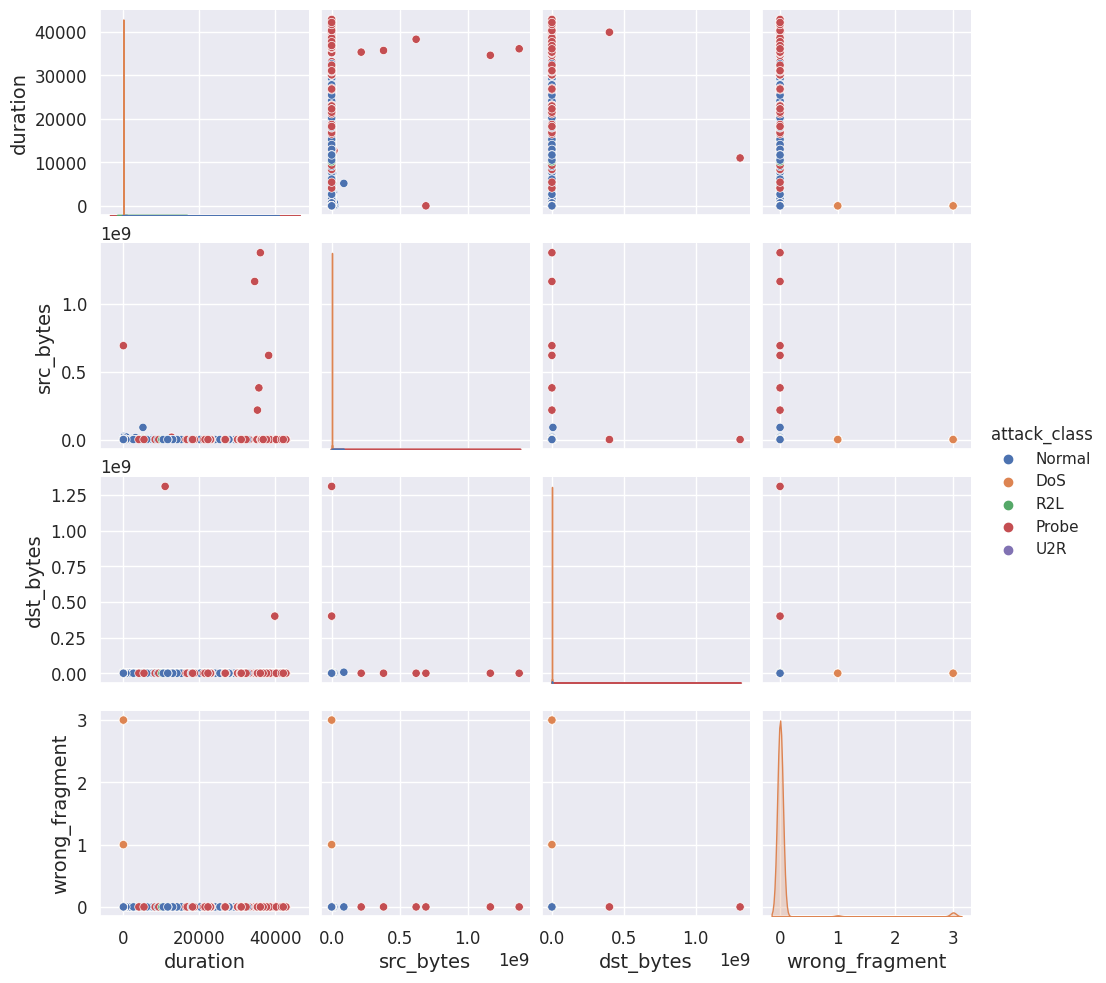

In [ ]:
# Pair plots for bi-variate analyis
sns.pairplot(dfkdd_train, hue='attack_class', vars=['duration', 'src_bytes', 'dst_bytes', 'wrong_fragment'])

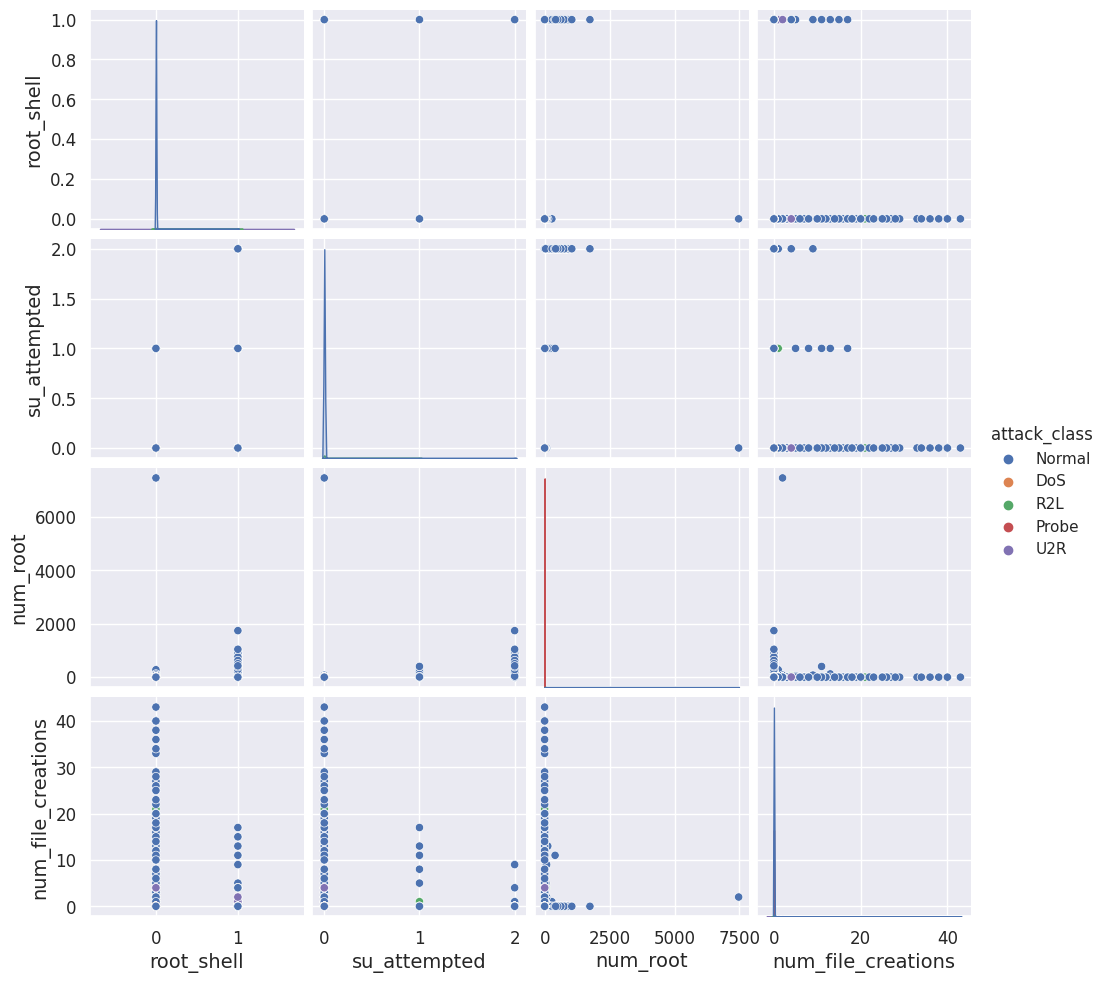

In [ ]:
sns.pairplot(dfkdd_train, hue='attack_class', vars=['root_shell','su_attempted','num_root','num_file_creations'])

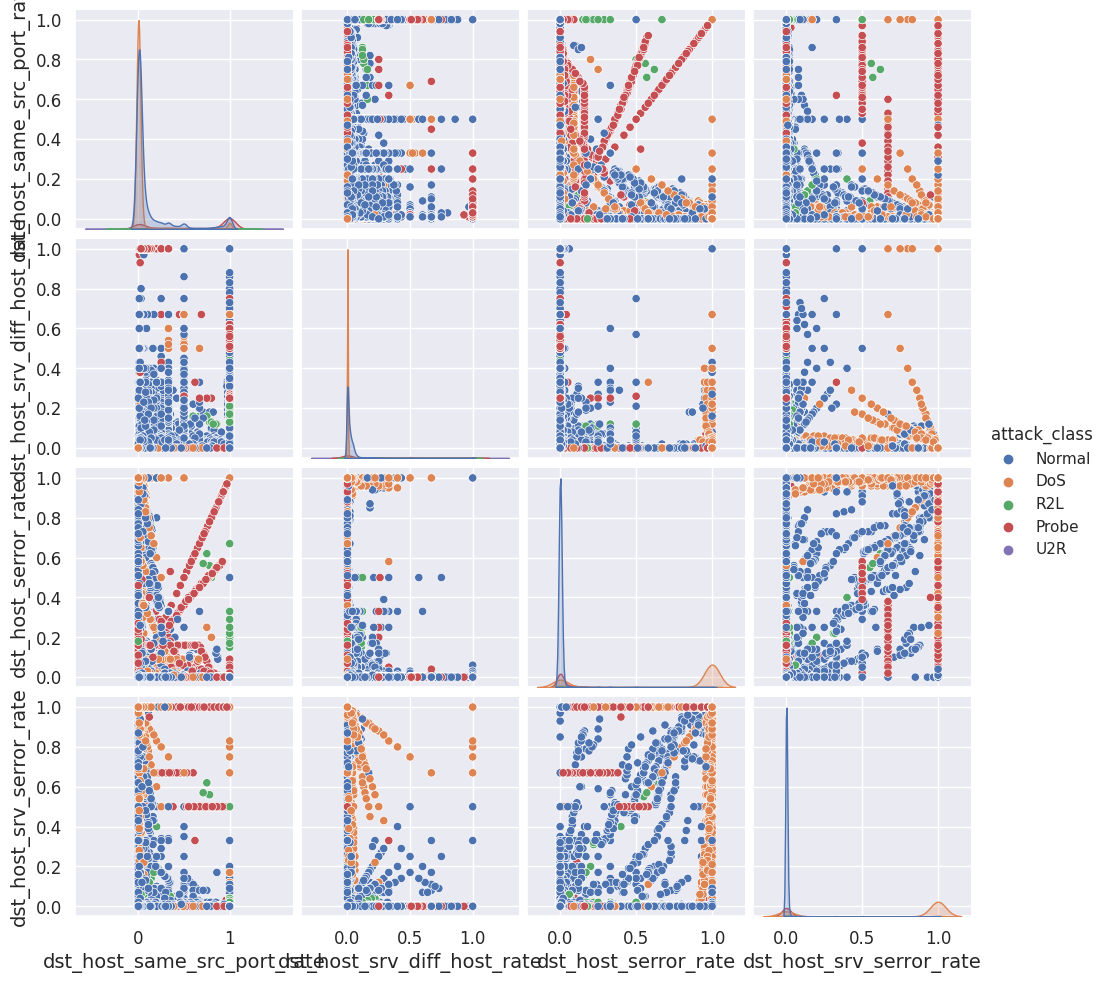

In [ ]:
sns.pairplot(dfkdd_train, hue='attack_class', vars=['dst_host_same_src_port_rate','dst_host_srv_diff_host_rate',
                                             'dst_host_serror_rate','dst_host_srv_serror_rate'])

In [ ]:
dfkdd_train.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack_class
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.00,0.00,0.00,150,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,Normal
1,0,udp,other,SF,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.0,0.0,0.0,0.0,0.08,0.15,0.00,255,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,Normal
2,0,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1.0,1.0,0.0,0.0,0.05,0.07,0.00,255,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,DoS
3,0,tcp,http,SF,232,8153,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,5,5,0.2,0.2,0.0,0.0,1.00,0.00,0.00,30,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,Normal
4,0,tcp,http,SF,199,420,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,30,32,0.0,0.0,0.0,0.0,1.00,0.00,0.09,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,Normal


### Scaling Numerical Attributes

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# extract numerical attributes and scale it to have zero mean and unit variance  
cols = dfkdd_train.select_dtypes(include=['float64','int64']).columns
sc_train = scaler.fit_transform(dfkdd_train.select_dtypes(include=['float64','int64']))
sc_test = scaler.fit_transform(dfkdd_test.select_dtypes(include=['float64','int64']))

# turn the result back to a dataframe
sc_traindf = pd.DataFrame(sc_train, columns = cols)
sc_testdf = pd.DataFrame(sc_test, columns = cols)

### Encoding of Categorical Attributes

In [ ]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

# extract categorical attributes from both training and test sets 
cattrain = dfkdd_train.select_dtypes(include=['object']).copy()
cattest = dfkdd_test.select_dtypes(include=['object']).copy()

# encode the categorical attributes
traincat = cattrain.apply(encoder.fit_transform)
testcat = cattest.apply(encoder.fit_transform)

# separate target column from encoded data 
enctrain = traincat.drop(['attack_class'], axis=1)
enctest = testcat.drop(['attack_class'], axis=1)

cat_Ytrain = traincat[['attack_class']].copy()
cat_Ytest = testcat[['attack_class']].copy()

### Data Sampling

In [ ]:
from imblearn.over_sampling import RandomOverSampler 
from collections import Counter

# define columns and extract encoded train set for sampling 
sc_traindf = dfkdd_train.select_dtypes(include=['float64','int64'])
refclasscol = pd.concat([sc_traindf, enctrain], axis=1).columns
refclass = np.concatenate((sc_train, enctrain.values), axis=1)
X = refclass

# reshape target column to 1D array shape  
c, r = cat_Ytest.values.shape
y_test = cat_Ytest.values.reshape(c,)

c, r = cat_Ytrain.values.shape
y = cat_Ytrain.values.reshape(c,)

# apply the random over-sampling
ros = RandomOverSampler(random_state=42)
X_res, y_res = ros.fit_resample(X, y)
print('Original dataset shape {}'.format(Counter(y)))
print('Resampled dataset shape {}'.format(Counter(y_res)))

Original dataset shape Counter({1: 67343, 0: 45927, 2: 11656, 3: 995, 4: 52})
Resampled dataset shape Counter({1: 67343, 0: 67343, 3: 67343, 2: 67343, 4: 67343})


### Feature Selection

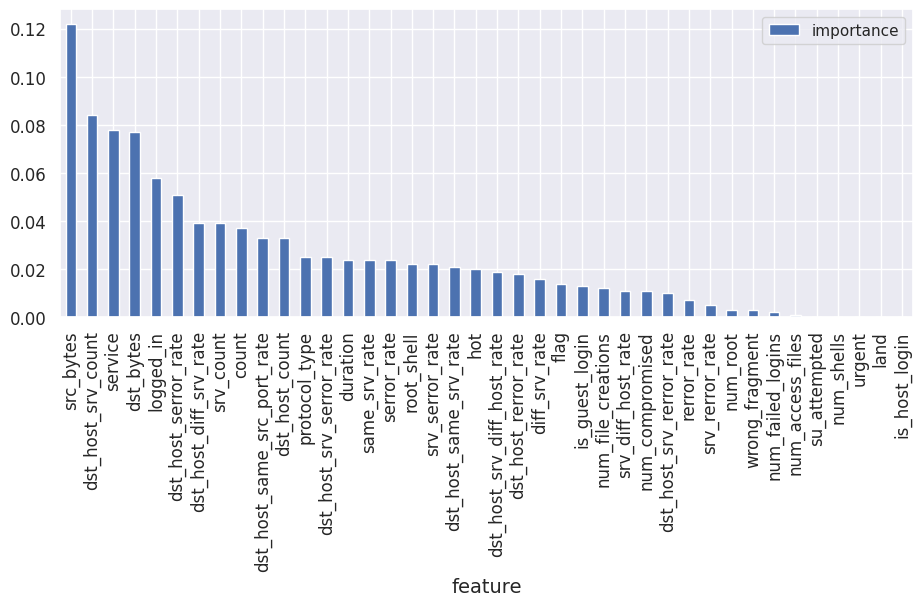

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier();

# fit random forest classifier on the training set
rfc.fit(X_res, y_res);
# extract important features
score = np.round(rfc.feature_importances_,3)
importances = pd.DataFrame({'feature':refclasscol,'importance':score})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
# plot importances
plt.rcParams['figure.figsize'] = (11, 4)
importances.plot.bar();

In [ ]:
selected_features = ['src_bytes', 'dst_bytes', 'logged_in', 'count', 'srv_count', 'dst_host_srv_count',
 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_serror_rate', 'service']


In [ ]:
selected_features

['src_bytes',
 'dst_bytes',
 'logged_in',
 'count',
 'srv_count',
 'dst_host_srv_count',
 'dst_host_diff_srv_rate',
 'dst_host_same_src_port_rate',
 'dst_host_serror_rate',
 'service']

### Dataset  Partition

In [ ]:
# define columns to new dataframe
newcol = list(refclasscol)
newcol.append('attack_class')

# add a dimension to target
new_y_res = y_res[:, np.newaxis]

# create a dataframe from sampled data
res_arr = np.concatenate((X_res, new_y_res), axis=1)
res_df = pd.DataFrame(res_arr, columns = newcol) 

# create test dataframe
reftest = pd.concat([sc_testdf, testcat], axis=1)
reftest['attack_class'] = reftest['attack_class'].astype(np.float64)
reftest['protocol_type'] = reftest['protocol_type'].astype(np.float64)
reftest['flag'] = reftest['flag'].astype(np.float64)
reftest['service'] = reftest['service'].astype(np.float64)

res_df.shape
reftest.shape

(22544, 41)

In [ ]:
from collections import defaultdict
classdict = defaultdict(list)

# create two-target classes (normal class and an attack class)  
attacklist = [('DoS', 0.0), ('Probe', 2.0), ('R2L', 3.0), ('U2R', 4.0)]
normalclass = [('Normal', 1.0)]

def create_classdict():
    '''This function subdivides train and test dataset into two-class attack labels''' 
    for j, k in normalclass: 
        for i, v in attacklist: 
            restrain_set = res_df.loc[(res_df['attack_class'] == k) | (res_df['attack_class'] == v)]
            classdict[j +'_' + i].append(restrain_set)
            # test labels
            reftest_set = reftest.loc[(reftest['attack_class'] == k) | (reftest['attack_class'] == v)]
            classdict[j +'_' + i].append(reftest_set)
        
create_classdict()

In [ ]:
for k, v in classdict.items():
    k

In [ ]:
pretrain = classdict['Normal_DoS'][0]
pretest = classdict['Normal_DoS'][1]
grpclass = 'Normal_DoS'

In [ ]:
pretrain_u2r = classdict['Normal_U2R'][0]
pretest_u2r = classdict['Normal_U2R'][1]
grpclass_u2r = 'Normal_U2R'

In [ ]:
pretrain_r2l = classdict['Normal_R2L'][0]
pretest_r2l = classdict['Normal_R2L'][1]
grpclass_r2l = 'Normal_R2L'

In [ ]:
pretrain_probe = classdict['Normal_Probe'][0]
pretest_probe = classdict['Normal_Probe'][1]
grpclass_probe = 'Normal_Probe'

### Finalize data preprocessing for training

In [ ]:
# DOS PREPROCESSING OF DATA
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')

Xresdf = pretrain 
newtest = pretest

Xresdfnew = Xresdf[selected_features]
Xresdfnum = Xresdfnew.drop(['service'], axis=1)
Xresdfcat = Xresdfnew[['service']].copy()

Xtest_features = newtest[selected_features]
Xtestdfnum = Xtest_features.drop(['service'], axis=1)
Xtestcat = Xtest_features[['service']].copy()


# Fit train data
enc.fit(Xresdfcat)

# Transform train data
X_train_1hotenc = enc.transform(Xresdfcat).toarray()
       
# Transform test data
X_test_1hotenc = enc.transform(Xtestcat).toarray()

X_train = np.concatenate((Xresdfnum.values, X_train_1hotenc), axis=1)
X_test = np.concatenate((Xtestdfnum.values, X_test_1hotenc), axis=1) 

y_train = Xresdf[['attack_class']].copy()
c, r = y_train.values.shape
Y_train = y_train.values.reshape(c,)

y_test = newtest[['attack_class']].copy()
c, r = y_test.values.shape
Y_test = y_test.values.reshape(c,)

In [ ]:
# U2R PREPROCESSING OF DATA
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')

Xresdf_u2r = pretrain_u2r 
newtest_u2r = pretest_u2r

Xresdfnew_u2r = Xresdf_u2r[selected_features]
Xresdfnum_u2r = Xresdfnew_u2r.drop(['service'], axis=1)
Xresdfcat_u2r = Xresdfnew_u2r[['service']].copy()

Xtest_features_u2r = newtest_u2r[selected_features]
Xtestdfnum_u2r = Xtest_features_u2r.drop(['service'], axis=1)
Xtestcat_u2r = Xtest_features_u2r[['service']].copy()


# Fit train data
enc.fit(Xresdfcat_u2r)

# Transform train data
X_train_1hotenc_u2r = enc.transform(Xresdfcat_u2r).toarray()
       
# Transform test data
X_test_1hotenc_u2r = enc.transform(Xtestcat_u2r).toarray()

X_train_u2r = np.concatenate((Xresdfnum_u2r.values, X_train_1hotenc_u2r), axis=1)
X_test_u2r = np.concatenate((Xtestdfnum_u2r.values, X_test_1hotenc_u2r), axis=1) 

y_train_u2r = Xresdf_u2r[['attack_class']].copy()
c, r = y_train_u2r.values.shape
Y_train_u2r = y_train_u2r.values.reshape(c,)

y_test_u2r = newtest_u2r[['attack_class']].copy()
c, r = y_test_u2r.values.shape
Y_test_u2r = y_test_u2r.values.reshape(c,)

In [ ]:
# r2l PREPROCESSING OF DATA
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')

Xresdf_r2l = pretrain_r2l 
newtest_r2l = pretest_r2l

Xresdfnew_r2l = Xresdf_r2l[selected_features]
Xresdfnum_r2l = Xresdfnew_r2l.drop(['service'], axis=1)
Xresdfcat_r2l = Xresdfnew_r2l[['service']].copy()

Xtest_features_r2l = newtest_r2l[selected_features]
Xtestdfnum_r2l = Xtest_features_r2l.drop(['service'], axis=1)
Xtestcat_r2l = Xtest_features_r2l[['service']].copy()


# Fit train data
enc.fit(Xresdfcat_r2l)

# Transform train data
X_train_1hotenc_r2l = enc.transform(Xresdfcat_r2l).toarray()
       
# Transform test data
X_test_1hotenc_r2l = enc.transform(Xtestcat_r2l).toarray()

X_train_r2l = np.concatenate((Xresdfnum_r2l.values, X_train_1hotenc_r2l), axis=1)
X_test_r2l = np.concatenate((Xtestdfnum_r2l.values, X_test_1hotenc_r2l), axis=1) 

y_train_r2l = Xresdf_r2l[['attack_class']].copy()
c, r = y_train_r2l.values.shape
Y_train_r2l = y_train_r2l.values.reshape(c,)

y_test_r2l = newtest_r2l[['attack_class']].copy()
c, r = y_test_r2l.values.shape
Y_test_r2l = y_test_r2l.values.reshape(c,)

In [ ]:
# probe PREPROCESSING OF DATA
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')

Xresdf_probe = pretrain_probe 
newtest_probe = pretest_probe

Xresdfnew_probe = Xresdf_probe[selected_features]
Xresdfnum_probe = Xresdfnew_probe.drop(['service'], axis=1)
Xresdfcat_probe = Xresdfnew_probe[['service']].copy()

Xtest_features_probe = newtest_probe[selected_features]
Xtestdfnum_probe = Xtest_features_probe.drop(['service'], axis=1)
Xtestcat_probe = Xtest_features_probe[['service']].copy()


# Fit train data
enc.fit(Xresdfcat_probe)

# Transform train data
X_train_1hotenc_probe = enc.transform(Xresdfcat_probe).toarray()
       
# Transform test data
X_test_1hotenc_probe = enc.transform(Xtestcat_probe).toarray()

X_train_probe = np.concatenate((Xresdfnum_probe.values, X_train_1hotenc_probe), axis=1)
X_test_probe = np.concatenate((Xtestdfnum_probe.values, X_test_1hotenc_probe), axis=1) 

y_train_probe = Xresdf_probe[['attack_class']].copy()
c, r = y_train_probe.values.shape
Y_train_probe = y_train_probe.values.reshape(c,)

y_test_probe = newtest_probe[['attack_class']].copy()
c, r = y_test_probe.values.shape
Y_test_probe = y_test_probe.values.reshape(c,)

## Train Models

In [ ]:
# DOS TRAINING 
from sklearn.svm import SVC 
from sklearn.naive_bayes import BernoulliNB 
from sklearn import tree
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier

# Train KNeighborsClassifier Model
KNN_Classifier = KNeighborsClassifier(n_jobs=-1)
KNN_Classifier.fit(X_train, Y_train); 

# Train LogisticRegression Model
LGR_Classifier = LogisticRegression(n_jobs=-1, random_state=0)
LGR_Classifier.fit(X_train, Y_train);

# Train Gaussian Naive Baye Model
BNB_Classifier = BernoulliNB()
BNB_Classifier.fit(X_train, Y_train)
            
# Train Decision Tree Model
DTC_Classifier = tree.DecisionTreeClassifier(criterion='entropy', random_state=0)
DTC_Classifier.fit(X_train, Y_train);
            
# Train RandomForestClassifier Model
#RF_Classifier = RandomForestClassifier(criterion='entropy', n_jobs=-1, random_state=0)
#RF_Classifier.fit(X_train, Y_train);  

# Train SVM Model
#SVC_Classifier = SVC(random_state=0)
#SVC_Classifier.fit(X_train, Y_train)

## Train Ensemble Model (This method combines all the individual models above except RandomForest)
#combined_model = [('Naive Baye Classifier', BNB_Classifier), 
#                  ('Decision Tree Classifier', DTC_Classifier), 
#                  ('KNeighborsClassifier', KNN_Classifier), 
#                  ('LogisticRegression', LGR_Classifier)
#                 ]
#VotingClassifier =  VotingClassifier(estimators = combined_model,voting = 'soft', n_jobs=-1)
#VotingClassifier.fit(X_train, Y_train);

In [ ]:
# U2R TRAINING
from sklearn.svm import SVC 
from sklearn.naive_bayes import BernoulliNB 
from sklearn import tree
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier

# Train KNeighborsClassifier Model
KNN_Classifier_u2r = KNeighborsClassifier(n_jobs=-1)
KNN_Classifier_u2r.fit(X_train_u2r, Y_train_u2r); 

# Train LogisticRegression Model
LGR_Classifier_u2r = LogisticRegression(n_jobs=-1, random_state=0)
LGR_Classifier_u2r.fit(X_train_u2r, Y_train_u2r);

# Train Gaussian Naive Baye Model
BNB_Classifier_u2r = BernoulliNB()
BNB_Classifier_u2r.fit(X_train_u2r, Y_train_u2r)
            
# Train Decision Tree Model
DTC_Classifier_u2r = tree.DecisionTreeClassifier(criterion='entropy', random_state=0)
DTC_Classifier_u2r.fit(X_train_u2r, Y_train_u2r);
            
# Train RandomForestClassifier Model
#RF_Classifier = RandomForestClassifier(criterion='entropy', n_jobs=-1, random_state=0)
#RF_Classifier.fit(X_train_u2r, Y_train_u2r);  

# Train SVM Model
#SVC_Classifier = SVC(random_state=0)
#SVC_Classifier.fit(X_train_u2r, Y_train_u2r)

## Train Ensemble Model (This method combines all the individual models above except RandomForest)
#combined_model = [('Naive Baye Classifier', BNB_Classifier_u2r), 
#                  ('Decision Tree Classifier', DTC_Classifier_u2r), 
#                  ('KNeighborsClassifier', KNN_Classifier_u2r), 
#                  ('LogisticRegression', LGR_Classifier_u2r)
#                 ]
#VotingClassifier =  VotingClassifier(estimators = combined_model,voting = 'soft', n_jobs=-1)
#VotingClassifier.fit(X_train_u2r, Y_train_u2r);

In [ ]:
# r2l TRAINING
from sklearn.svm import SVC 
from sklearn.naive_bayes import BernoulliNB 
from sklearn import tree
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier

# Train KNeighborsClassifier Model
KNN_Classifier_r2l = KNeighborsClassifier(n_jobs=-1)
KNN_Classifier_r2l.fit(X_train_r2l, Y_train_r2l); 

# Train LogisticRegression Model
LGR_Classifier_r2l = LogisticRegression(n_jobs=-1, random_state=0)
LGR_Classifier_r2l.fit(X_train_r2l, Y_train_r2l);

# Train Gaussian Naive Baye Model
BNB_Classifier_r2l = BernoulliNB()
BNB_Classifier_r2l.fit(X_train_r2l, Y_train_r2l)
            
# Train Decision Tree Model
DTC_Classifier_r2l = tree.DecisionTreeClassifier(criterion='entropy', random_state=0)
DTC_Classifier_r2l.fit(X_train_r2l, Y_train_r2l);
            
# Train RandomForestClassifier Model
#RF_Classifier = RandomForestClassifier(criterion='entropy', n_jobs=-1, random_state=0)
#RF_Classifier.fit(X_train_r2l, Y_train_r2l);  

# Train SVM Model
#SVC_Classifier = SVC(random_state=0)
#SVC_Classifier.fit(X_train_r2l, Y_train_r2l)

## Train Ensemble Model (This method combines all the individual models above except RandomForest)
#combined_model = [('Naive Baye Classifier', BNB_Classifier_r2l), 
#                  ('Decision Tree Classifier', DTC_Classifier_r2l), 
#                  ('KNeighborsClassifier', KNN_Classifier_r2l), 
#                  ('LogisticRegression', LGR_Classifier_r2l)
#                 ]
#VotingClassifier =  VotingClassifier(estimators = combined_model,voting = 'soft', n_jobs=-1)
#VotingClassifier.fit(X_train_r2l, Y_train_r2l);

In [ ]:
# probe TRAINING
from sklearn.svm import SVC 
from sklearn.naive_bayes import BernoulliNB 
from sklearn import tree
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier

# Train KNeighborsClassifier Model
KNN_Classifier_probe = KNeighborsClassifier(n_jobs=-1)
KNN_Classifier_probe.fit(X_train_probe, Y_train_probe); 

# Train LogisticRegression Model
LGR_Classifier_probe = LogisticRegression(n_jobs=-1, random_state=0)
LGR_Classifier_probe.fit(X_train_probe, Y_train_probe);

# Train Gaussian Naive Baye Model
BNB_Classifier_probe = BernoulliNB()
BNB_Classifier_probe.fit(X_train_probe, Y_train_probe)
            
# Train Decision Tree Model
DTC_Classifier_probe = tree.DecisionTreeClassifier(criterion='entropy', random_state=0)
DTC_Classifier_probe.fit(X_train_probe, Y_train_probe);
            
# Train RandomForestClassifier Model
#RF_Classifier = RandomForestClassifier(criterion='entropy', n_jobs=-1, random_state=0)
#RF_Classifier.fit(X_train_probe, Y_train_probe);  

# Train SVM Model
#SVC_Classifier = SVC(random_state=0)
#SVC_Classifier.fit(X_train_probe, Y_train_probe)

## Train Ensemble Model (This method combines all the individual models above except RandomForest)
#combined_model = [('Naive Baye Classifier', BNB_Classifier_probe), 
#                  ('Decision Tree Classifier', DTC_Classifier_probe), 
#                  ('KNeighborsClassifier', KNN_Classifier_probe), 
#                  ('LogisticRegression', LGR_Classifier_probe)
#                 ]
#VotingClassifier =  VotingClassifier(estimators = combined_model,voting = 'soft', n_jobs=-1)
#VotingClassifier.fit(X_train_probe, Y_train_probe);

## Evaluate Models

In [ ]:
#DOS EVALUATION
from sklearn import metrics

models = []
#models.append(('SVM Classifier', SVC_Classifier))
models.append(('Naive Baye Classifier', BNB_Classifier))
models.append(('Decision Tree Classifier', DTC_Classifier))
#models.append(('RandomForest Classifier', RF_Classifier))
models.append(('KNeighborsClassifier', KNN_Classifier))
models.append(('LogisticRegression', LGR_Classifier))
#models.append(('VotingClassifier', VotingClassifier))

for i, v in models:
    scores = cross_val_score(v, X_train, Y_train, cv=10)
    accuracy = metrics.accuracy_score(Y_train, v.predict(X_train))
    confusion_matrix = metrics.confusion_matrix(Y_train, v.predict(X_train))
    classification = metrics.classification_report(Y_train, v.predict(X_train))
    print()
    print('============================== {} {} Model Evaluation =============================='.format(grpclass, i))
    print()
    print ("Cross Validation Mean Score:" "\n", scores.mean())
    print()
    print ("Model Accuracy:" "\n", accuracy)
    print()
    print("Confusion matrix:" "\n", confusion_matrix)
    print()
    print("Classification report:" "\n", classification) 
    print()


============================== Normal_DoS Naive Baye Classifier Model Evaluation ==============================

Cross Validation Mean Score:
 0.9737760413571536

Model Accuracy:
 0.9737686173767133

Confusion matrix:
 [[65346  1997]
 [ 1536 65807]]

Classification report:
               precision    recall  f1-score   support

         0.0       0.98      0.97      0.97     67343
         1.0       0.97      0.98      0.97     67343

    accuracy                           0.97    134686
   macro avg       0.97      0.97      0.97    134686
weighted avg       0.97      0.97      0.97    134686



============================== Normal_DoS Decision Tree Classifier Model Evaluation ==============================

Cross Validation Mean Score:
 0.9997698368976862

Model Accuracy:
 0.9999480272634127

Confusion matrix:
 [[67343     0]
 [    7 67336]]

Classification report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     67343
        

In [ ]:
# U2R EVALUATION
from sklearn import metrics

models = []
#models.append(('SVM Classifier', SVC_Classifier))
models.append(('Naive Baye Classifier', BNB_Classifier_u2r))
models.append(('Decision Tree Classifier', DTC_Classifier_u2r))
#models.append(('RandomForest Classifier', RF_Classifier_u2r))
models.append(('KNeighborsClassifier', KNN_Classifier_u2r))
models.append(('LogisticRegression', LGR_Classifier_u2r))
#models.append(('VotingClassifier', VotingClassifier_u2r))

for i, v in models:
    scores = cross_val_score(v, X_train_u2r, Y_train_u2r, cv=10)
    accuracy = metrics.accuracy_score(Y_train_u2r, v.predict(X_train_u2r))
    confusion_matrix = metrics.confusion_matrix(Y_train_u2r, v.predict(X_train_u2r))
    classification = metrics.classification_report(Y_train_u2r, v.predict(X_train_u2r))
    print()
    print('============================== {} {} Model Evaluation =============================='.format(grpclass_u2r, i))
    print()
    print ("Cross Validation Mean Score:" "\n", scores.mean())
    print()
    print ("Model Accuracy:" "\n", accuracy)
    print()
    print("Confusion matrix:" "\n", confusion_matrix)
    print()
    print("Classification report:" "\n", classification) 
    print()


============================== Normal_U2R Naive Baye Classifier Model Evaluation ==============================

Cross Validation Mean Score:
 0.9332150405633961

Model Accuracy:
 0.9332150334852917

Confusion matrix:
 [[59684  7659]
 [ 1336 66007]]

Classification report:
               precision    recall  f1-score   support

         1.0       0.98      0.89      0.93     67343
         4.0       0.90      0.98      0.94     67343

    accuracy                           0.93    134686
   macro avg       0.94      0.93      0.93    134686
weighted avg       0.94      0.93      0.93    134686



============================== Normal_U2R Decision Tree Classifier Model Evaluation ==============================

Cross Validation Mean Score:
 0.9998812064963969

Model Accuracy:
 0.9999925753233446

Confusion matrix:
 [[67342     1]
 [    0 67343]]

Classification report:
               precision    recall  f1-score   support

         1.0       1.00      1.00      1.00     67343
        

In [ ]:
#R2L EVALUATION
from sklearn import metrics

models = []
#models.append(('SVM Classifier', SVC_Classifier))
models.append(('Naive Baye Classifier', BNB_Classifier_r2l))
models.append(('Decision Tree Classifier', DTC_Classifier_r2l))
#models.append(('RandomForest Classifier', RF_Classifier_r2l))
models.append(('KNeighborsClassifier', KNN_Classifier_r2l))
models.append(('LogisticRegression', LGR_Classifier_r2l))
#models.append(('VotingClassifier', VotingClassifier_r2l))

for i, v in models:
    scores = cross_val_score(v, X_train_r2l, Y_train_r2l, cv=10)
    accuracy = metrics.accuracy_score(Y_train_r2l, v.predict(X_train_r2l))
    confusion_matrix = metrics.confusion_matrix(Y_train_r2l, v.predict(X_train_r2l))
    classification = metrics.classification_report(Y_train_r2l, v.predict(X_train_r2l))
    print()
    print('============================== {} {} Model Evaluation =============================='.format(grpclass_r2l, i))
    print()
    print ("Cross Validation Mean Score:" "\n", scores.mean())
    print()
    print ("Model Accuracy:" "\n", accuracy)
    print()
    print("Confusion matrix:" "\n", confusion_matrix)
    print()
    print("Classification report:" "\n", classification) 
    print()


============================== Normal_R2L Naive Baye Classifier Model Evaluation ==============================

Cross Validation Mean Score:
 0.9458741082135542

Model Accuracy:
 0.9458889565359428

Confusion matrix:
 [[60320  7023]
 [  265 67078]]

Classification report:
               precision    recall  f1-score   support

         1.0       1.00      0.90      0.94     67343
         3.0       0.91      1.00      0.95     67343

    accuracy                           0.95    134686
   macro avg       0.95      0.95      0.95    134686
weighted avg       0.95      0.95      0.95    134686



============================== Normal_R2L Decision Tree Classifier Model Evaluation ==============================

Cross Validation Mean Score:
 0.9997475624266775

Model Accuracy:
 1.0

Confusion matrix:
 [[67343     0]
 [    0 67343]]

Classification report:
               precision    recall  f1-score   support

         1.0       1.00      1.00      1.00     67343
         3.0       1.00

In [ ]:
# PROBE EVALUATION
from sklearn import metrics

models = []
#models.append(('SVM Classifier', SVC_Classifier))
models.append(('Naive Baye Classifier', BNB_Classifier_probe))
models.append(('Decision Tree Classifier', DTC_Classifier_probe))
#models.append(('RandomForest Classifier', RF_Classifier_probe))
models.append(('KNeighborsClassifier', KNN_Classifier_probe))
models.append(('LogisticRegression', LGR_Classifier_probe))
#models.append(('VotingClassifier', VotingClassifier_probe))

for i, v in models:
    scores = cross_val_score(v, X_train_probe, Y_train_probe, cv=10)
    accuracy = metrics.accuracy_score(Y_train_probe, v.predict(X_train_probe))
    confusion_matrix = metrics.confusion_matrix(Y_train_probe, v.predict(X_train_probe))
    classification = metrics.classification_report(Y_train_probe, v.predict(X_train_probe))
    print()
    print('============================== {} {} Model Evaluation =============================='.format(grpclass_probe, i))
    print()
    print ("Cross Validation Mean Score:" "\n", scores.mean())
    print()
    print ("Model Accuracy:" "\n", accuracy)
    print()
    print("Confusion matrix:" "\n", confusion_matrix)
    print()
    print("Classification report:" "\n", classification) 
    print()


============================== Normal_Probe Naive Baye Classifier Model Evaluation ==============================

Cross Validation Mean Score:
 0.9520440313910505

Model Accuracy:
 0.9520143147765915

Confusion matrix:
 [[61583  5760]
 [  703 66640]]

Classification report:
               precision    recall  f1-score   support

         1.0       0.99      0.91      0.95     67343
         2.0       0.92      0.99      0.95     67343

    accuracy                           0.95    134686
   macro avg       0.95      0.95      0.95    134686
weighted avg       0.95      0.95      0.95    134686



============================== Normal_Probe Decision Tree Classifier Model Evaluation ==============================

Cross Validation Mean Score:
 0.9995990705471736

Model Accuracy:
 0.9999925753233446

Confusion matrix:
 [[67342     1]
 [    0 67343]]

Classification report:
               precision    recall  f1-score   support

         1.0       1.00      1.00      1.00     67343
    

## Test Models

In [ ]:
# DOS TEST RESULTS
for i, v in models:
    accuracy = metrics.accuracy_score(Y_test, v.predict(X_test))
    confusion_matrix = metrics.confusion_matrix(Y_test, v.predict(X_test))
    classification = metrics.classification_report(Y_test, v.predict(X_test))
    print()
    print('============================== {} {} Model Test Results =============================='.format(grpclass, i))
    print()
    print ("Model Accuracy:" "\n", accuracy)
    print()
    print("Confusion matrix:" "\n", confusion_matrix)
    print()
    print("Classification report:" "\n", classification) 
    print()        



============================== Normal_DoS Naive Baye Classifier Model Test Results ==============================

Model Accuracy:
 0.8336536781408352

Confusion matrix:
 [[5487 1971]
 [ 885 8826]]

Classification report:
               precision    recall  f1-score   support

         0.0       0.86      0.74      0.79      7458
         1.0       0.82      0.91      0.86      9711

    accuracy                           0.83     17169
   macro avg       0.84      0.82      0.83     17169
weighted avg       0.84      0.83      0.83     17169



============================== Normal_DoS Decision Tree Classifier Model Test Results ==============================

Model Accuracy:
 0.8165880365775525

Confusion matrix:
 [[5591 1867]
 [1282 8429]]

Classification report:
               precision    recall  f1-score   support

         0.0       0.81      0.75      0.78      7458
         1.0       0.82      0.87      0.84      9711

    accuracy                           0.82     17169
   

In [ ]:
# U2R TEST RESULTS
for i, v in models:
    accuracy = metrics.accuracy_score(Y_test_u2r, v.predict(X_test_u2r))
    confusion_matrix = metrics.confusion_matrix(Y_test_u2r, v.predict(X_test_u2r))
    classification = metrics.classification_report(Y_test_u2r, v.predict(X_test_u2r))
    print()
    print('============================== {} {} Model Test Results =============================='.format(grpclass_u2r, i))
    print()
    print ("Model Accuracy:" "\n", accuracy)
    print()
    print("Confusion matrix:" "\n", confusion_matrix)
    print()
    print("Classification report:" "\n", classification) 
    print()        



============================== Normal_U2R Naive Baye Classifier Model Test Results ==============================

Model Accuracy:
 0.9103016849964686

Confusion matrix:
 [[8982  729]
 [ 160   40]]

Classification report:
               precision    recall  f1-score   support

         1.0       0.98      0.92      0.95      9711
         4.0       0.05      0.20      0.08       200

    accuracy                           0.91      9911
   macro avg       0.52      0.56      0.52      9911
weighted avg       0.96      0.91      0.94      9911



============================== Normal_U2R Decision Tree Classifier Model Test Results ==============================

Model Accuracy:
 0.9798204015740086

Confusion matrix:
 [[9711    0]
 [ 200    0]]

Classification report:
               precision    recall  f1-score   support

         1.0       0.98      1.00      0.99      9711
         4.0       0.00      0.00      0.00       200

    accuracy                           0.98      9911
   

In [ ]:
# R2L TEST RESULTS
for i, v in models:
    accuracy = metrics.accuracy_score(Y_test_r2l, v.predict(X_test_r2l))
    confusion_matrix = metrics.confusion_matrix(Y_test_r2l, v.predict(X_test_r2l))
    classification = metrics.classification_report(Y_test_r2l, v.predict(X_test_r2l))
    print()
    print('============================== {} {} Model Test Results =============================='.format(grpclass_r2l, i))
    print()
    print ("Model Accuracy:" "\n", accuracy)
    print()
    print("Confusion matrix:" "\n", confusion_matrix)
    print()
    print("Classification report:" "\n", classification) 
    print()   


============================== Normal_R2L Naive Baye Classifier Model Test Results ==============================

Model Accuracy:
 0.7591656638588047

Confusion matrix:
 [[8963  748]
 [2254  500]]

Classification report:
               precision    recall  f1-score   support

         1.0       0.80      0.92      0.86      9711
         3.0       0.40      0.18      0.25      2754

    accuracy                           0.76     12465
   macro avg       0.60      0.55      0.55     12465
weighted avg       0.71      0.76      0.72     12465



============================== Normal_R2L Decision Tree Classifier Model Test Results ==============================

Model Accuracy:
 0.7820296831127156

Confusion matrix:
 [[9082  629]
 [2088  666]]

Classification report:
               precision    recall  f1-score   support

         1.0       0.81      0.94      0.87      9711
         3.0       0.51      0.24      0.33      2754

    accuracy                           0.78     12465
   

In [ ]:
# PROBE TEST RESULTS
for i, v in models:
    accuracy = metrics.accuracy_score(Y_test_probe, v.predict(X_test_probe))
    confusion_matrix = metrics.confusion_matrix(Y_test_probe, v.predict(X_test_probe))
    classification = metrics.classification_report(Y_test_probe, v.predict(X_test_probe))
    print()
    print('============================== {} {} Model Test Results =============================='.format(grpclass_probe, i))
    print()
    print ("Model Accuracy:" "\n", accuracy)
    print()
    print("Confusion matrix:" "\n", confusion_matrix)
    print()
    print("Classification report:" "\n", classification) 
    print()   


============================== Normal_Probe Naive Baye Classifier Model Test Results ==============================

Model Accuracy:
 0.827316188592153

Confusion matrix:
 [[8133 1578]
 [ 517 1904]]

Classification report:
               precision    recall  f1-score   support

         1.0       0.94      0.84      0.89      9711
         2.0       0.55      0.79      0.65      2421

    accuracy                           0.83     12132
   macro avg       0.74      0.81      0.77     12132
weighted avg       0.86      0.83      0.84     12132



============================== Normal_Probe Decision Tree Classifier Model Test Results ==============================

Model Accuracy:
 0.801763930102209

Confusion matrix:
 [[7658 2053]
 [ 352 2069]]

Classification report:
               precision    recall  f1-score   support

         1.0       0.96      0.79      0.86      9711
         2.0       0.50      0.85      0.63      2421

    accuracy                           0.80     12132
 